In [1]:
from matplotlib import patches
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import colors
from scipy import signal
from scipy.signal import find_peaks
import copy
from scipy.signal import butter, filtfilt
from scipy.signal import czt
from scipy.optimize import least_squares
from scipy.signal import spectrogram

In [2]:
#read data
file_path = './FMCW Radar/Rawdata/Rawdata_1.csv'
def readCsv(pathFile):
    arrays = []

    with open(pathFile, 'r') as file:
        # Read the lines of the file
        lines = file.readlines()
        for line in lines:
            line_values = line.strip().split(',')
            arrays.append(line_values)
    complex_array = []
    for array in arrays:

        complex_value = np.array(
            [complex(element.replace('i', 'j')) for element in array])
        complex_array.append(complex_value)
    np.array(complex_array)
    return np.array(complex_array)
raw_data = readCsv(file_path)
raw_data_channel_0 = raw_data[0]


In [3]:
T_c = 91.72 * (1e-6)   # Chirp time
f_start = 60.25*(1e9)  # Hz
NUM_SAMPLE_CHIRP = 256
SAMPLING_RATE = 3000000
B =3.75 * (1e9) #bandwidth
# Calculate frequency variation
wavelength=3.947
RANGE_RESOLUTION=4 # 4cm
MAX_RANGE=1100#11 m = 1100 cm
speed_of_light = 299792458

![Screenshot 2023-11-03 at 1.12.06 PM.png](<attachment:Screenshot 2023-11-03 at 1.12.06 PM.png>)
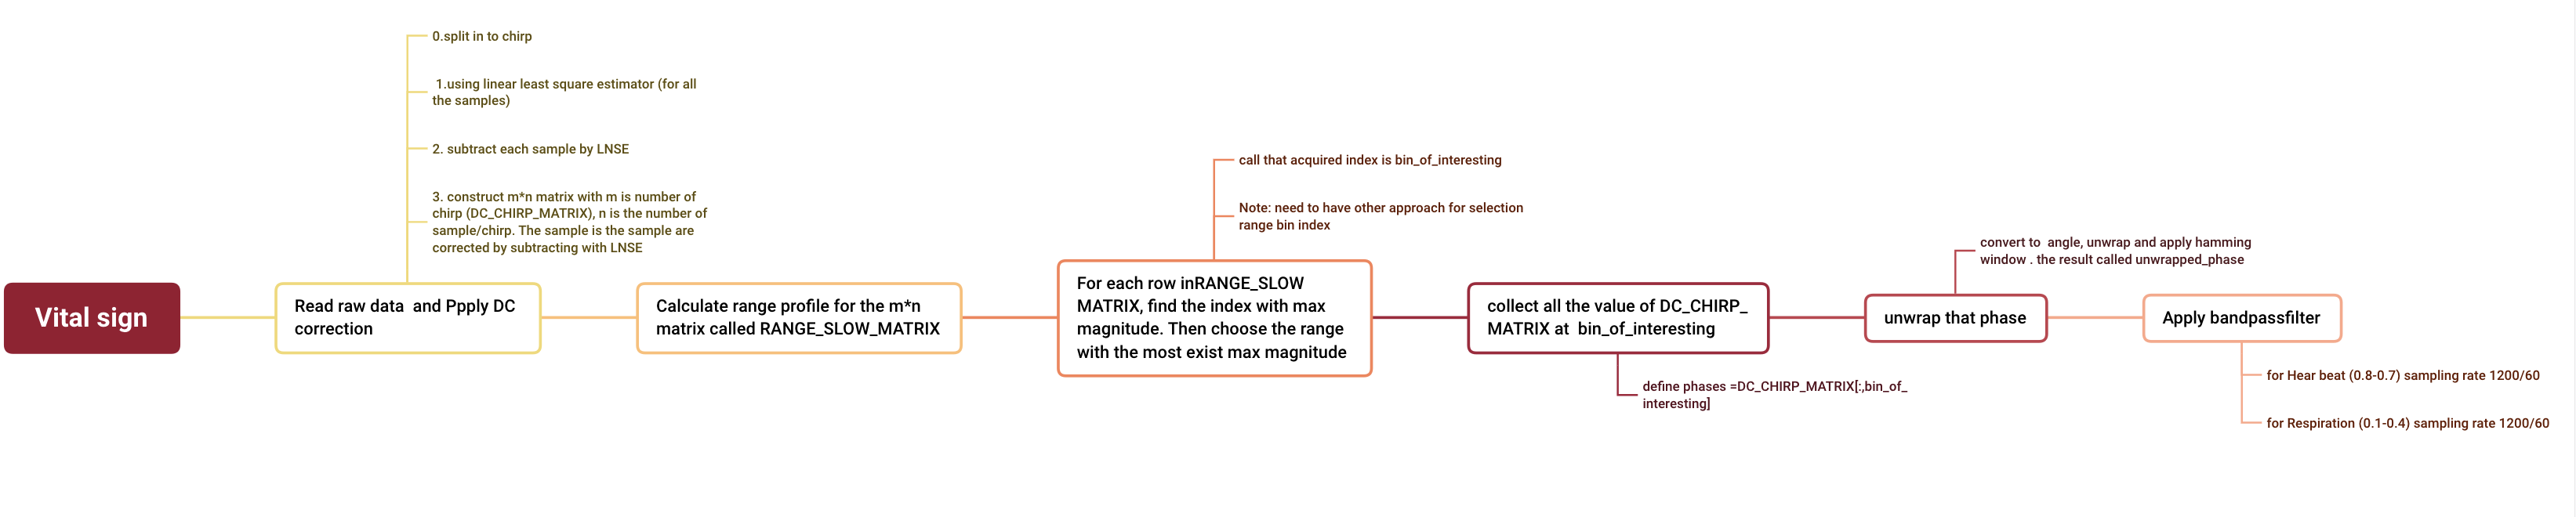

In [4]:
print(len(raw_data_channel_0))
chirps = [raw_data_channel_0[i:i+NUM_SAMPLE_CHIRP*2] for i in range(0, len(raw_data_channel_0), NUM_SAMPLE_CHIRP*2)]
first_chirps_of_frame = [chirps[j] for j in range(0, len(chirps), 1)]
print(np.array(first_chirps_of_frame).shape)


3072000
(6000, 512)


In [5]:
def residuals(params, x1, x2):
    a, b, c = params
    return (x1 - a)**2 + (x2 - b)**2 - c

initial_params=np.array([0.5,0.5,0.5])
real_parts = []
imag_parts = []
IFchirps = np.array(first_chirps_of_frame).flatten()
for IFchirp in IFchirps:
    real_parts.append(IFchirp.real)
    imag_parts.append(IFchirp.imag)
r_result = least_squares(residuals, initial_params, args=(np.array(real_parts).flatten(), (np.array(imag_parts).flatten())))


In [6]:
a,b,c =r_result.x
DC_compensation =a+b*1j 
DC_corrected_chirps = [ (first_chirp -DC_compensation) for first_chirp in first_chirps_of_frame]

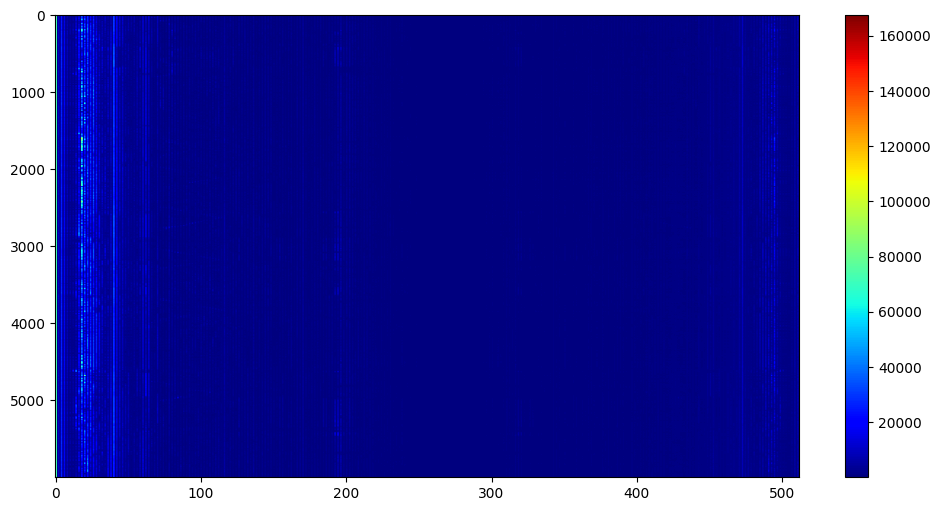

In [7]:
chirps_range_profiles = [np.fft.fft(chirp) for chirp in first_chirps_of_frame]
chirp_magnitudes = [np.abs(range_profile) for range_profile in chirps_range_profiles]

plt.figure(figsize=(12, 6))
plt.imshow(chirp_magnitudes,aspect='auto',cmap='jet')
plt.colorbar()
plt.show()

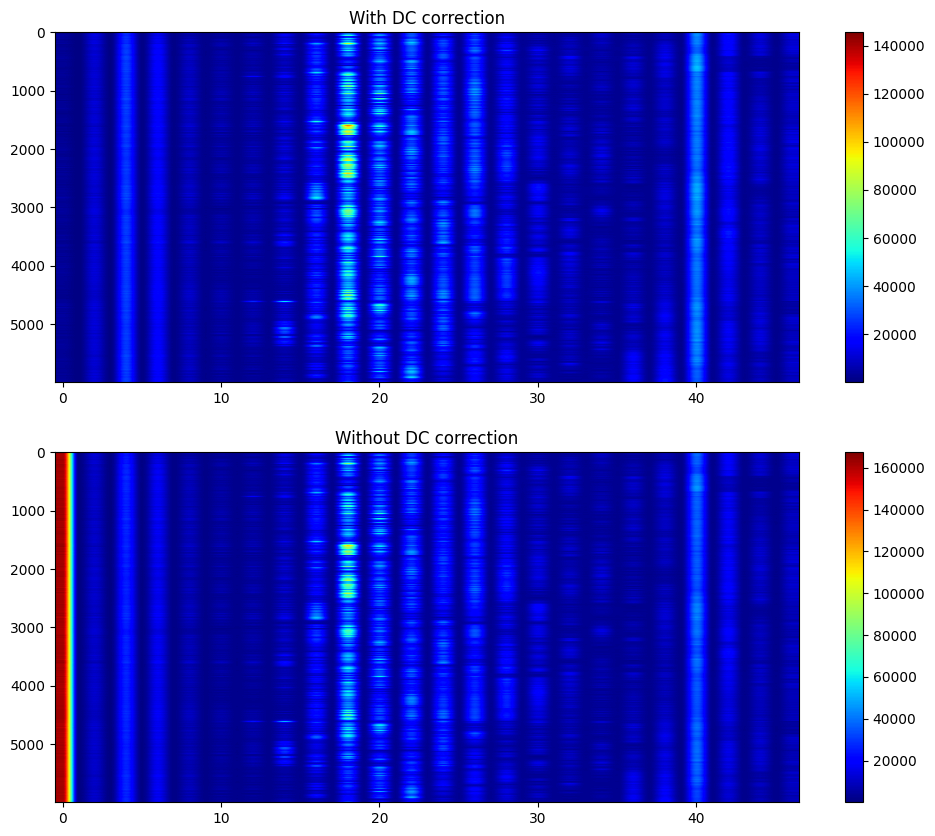

In [8]:
DC_corrected_chirps_range_profile = [np.fft.fft(DC_corrected_chirp) for DC_corrected_chirp in DC_corrected_chirps]
DC_corrected_magnitude = [np.abs(DC_corrected_chirps_fft) for DC_corrected_chirps_fft in DC_corrected_chirps_range_profile]


fft_chirps =[np.fft.fft(chirp) for chirp in first_chirps_of_frame]
abs_chirps =[np.abs(np.fft.fft(chirp)) for chirp in first_chirps_of_frame]



# for tmp_dc  in DC_corrected_magnitude:
#     tmp_dc[0]=140000
#     tmp_dc[2]=140000
#     tmp_dc[4]=140000
#     tmp_dc[6]=140000
#     tmp_dc[8]=140000
#     tmp_dc[12]=140000
#     tmp_dc[14]=140000
#     tmp_dc[16]=140000
#     tmp_dc[20]=140000


plt.figure(figsize=(12, 10))

plt.subplot(211)

plt.imshow(np.array(DC_corrected_magnitude)[:,0:47],aspect='auto',cmap='jet')
plt.title("With DC correction")
plt.colorbar()

plt.subplot(212)

plt.imshow(np.array(abs_chirps)[:,0:47],cmap='jet',aspect='auto')
plt.title("Without DC correction")
plt.colorbar()

plt.show()

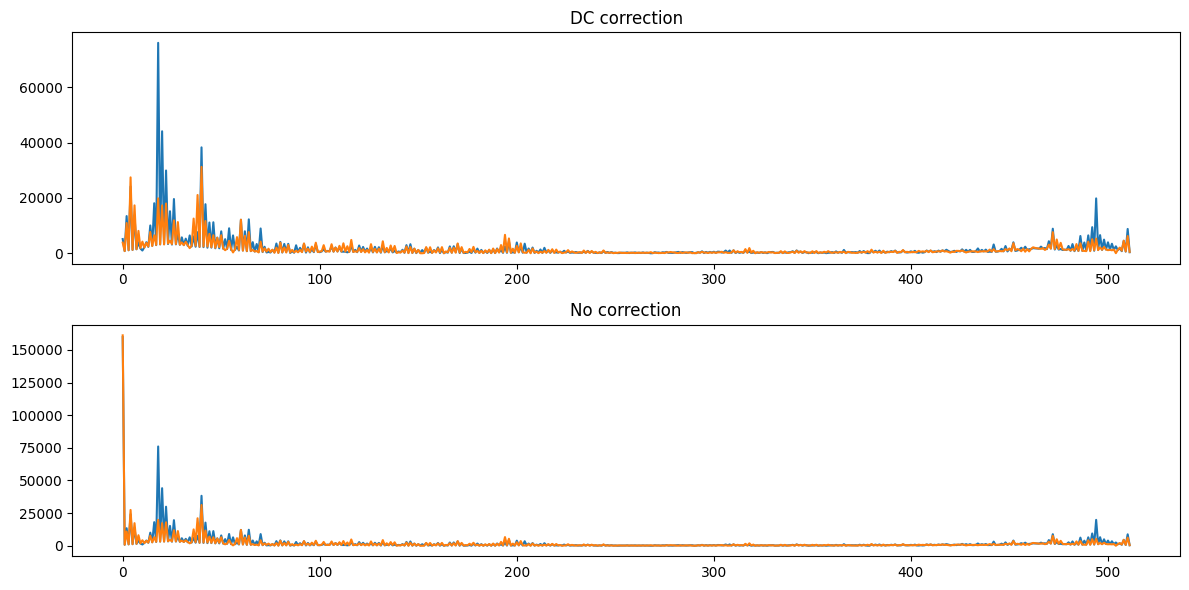

In [9]:
plt.figure(figsize=(12, 6))
plt.subplot(2,1,1)
plt.plot(DC_corrected_magnitude[0])
plt.plot(DC_corrected_magnitude[-1])
plt.title("DC correction")

plt.subplot(2,1,2)
plt.plot(chirp_magnitudes[0])
plt.plot(chirp_magnitudes[-1])
plt.title("No correction")
plt.tight_layout()
plt.show()

(200,)


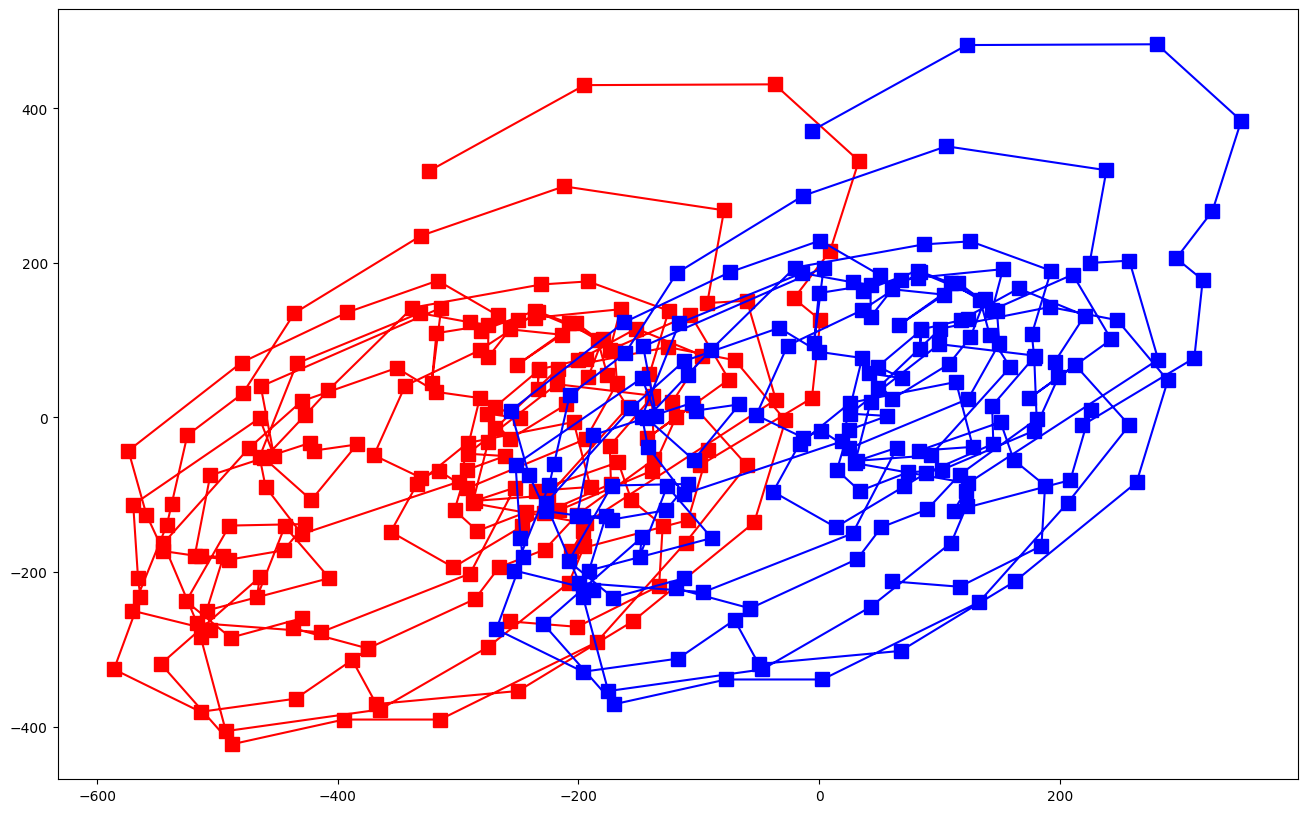

In [10]:

raw_chirps = (np.array(first_chirps_of_frame).flatten())[0:200]
raw_chirps_real = [raw_chirp.real for raw_chirp in raw_chirps]
raw_chirps_image = [raw_chirp.imag for raw_chirp in raw_chirps]

print( np.array(raw_chirps_real).shape)

dc_chirps  =(np.array(DC_corrected_chirps).flatten()) [0:200]
DC_corrected_real = [dc_chirp.real for dc_chirp in dc_chirps]
DC_corrected_image =[dc_chirp.imag for dc_chirp in dc_chirps]

plt.figure(figsize=(16, 10))

plt.plot(raw_chirps_real, raw_chirps_image, 'rs-', markeredgewidth=1, markersize=10,linewidth=0)
plt.plot(raw_chirps_real, raw_chirps_image, color='red')

plt.plot(DC_corrected_real, DC_corrected_image, 'bs-', markeredgewidth=1, markersize=10,linewidth=0)
plt.plot(DC_corrected_real, DC_corrected_image, color='blue')

plt.show()


In [11]:
magnitude_index = np.zeros(shape=len(DC_corrected_magnitude))
for  magnitude_spectrum in DC_corrected_magnitude:
    magnitude = np.abs(magnitude_spectrum)
    max_index=np.argmax(magnitude_spectrum[0:-1])
    # max_value = max(magnitude[1:-1])
    # max_index = np.where(max_value == magnitude)[0]
    magnitude_index[max_index]+=1
max_bin = max(magnitude_index)
bin_of_interest = np.where(max_bin ==magnitude_index )[0]

for i,val in enumerate(magnitude_index):
    if(0!=val):
        print("index:",i," : ",val)
print("bin of interest: ",bin_of_interest)

index: 14  :  38.0
index: 16  :  153.0
index: 18  :  2731.0
index: 20  :  837.0
index: 22  :  502.0
index: 24  :  186.0
index: 26  :  53.0
index: 40  :  1500.0
bin of interest:  [18]


In [12]:

interested_bin_phase =np.array(DC_corrected_chirps)[:,bin_of_interest]
interested_bin_angle =np.unwrap(np.angle(interested_bin_phase))

windowed_signal = interested_bin_angle.flatten() * np.hanning(len(interested_bin_angle))
hamming_windowed_signal = interested_bin_angle.flatten() * np.hamming(len(interested_bin_angle))



In [31]:
# try to apply DACM on interested_bin_phase
#I :real
#Q :imagine
phase_len =len(interested_bin_phase)


phase_k = np.zeros(shape=(np.array(interested_bin_phase).shape),dtype=float)
phase_k[0]=np.angle(interested_bin_phase[0])
phase_k[1]=np.angle(interested_bin_phase[1])
for i in range(2,phase_len):
    I_k=interested_bin_phase[i].real
    Q_k=interested_bin_phase[i].imag

    I_k_1=interested_bin_phase[i-1].real
    Q_k_1=interested_bin_phase[i-1].imag
    
    phase_k[i]+= (I_k * (Q_k -Q_k_1) -(I_k - I_k_1)* Q_k)/(I_k*I_k + Q_k * Q_k)
    

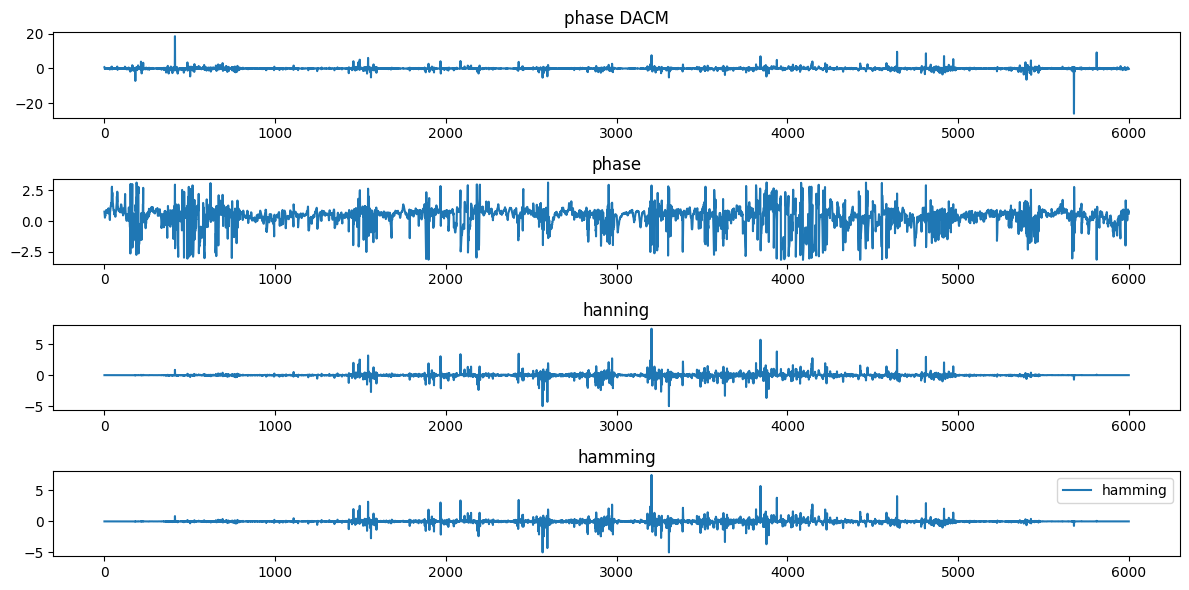

In [39]:
plt.figure(figsize=(12,6))
plt.subplot(4,1,1)
plt.plot(phase_k,label='phase DACM')
plt.title("phase DACM")

plt.subplot(4,1,2)
plt.plot(interested_bin_angle,label='phase')
plt.title("phase")


windowed_signal_phase_k_hanning = phase_k.flatten() * np.hanning(len(phase_k))
plt.subplot(4,1,3)
plt.plot(windowed_signal_phase_k_hanning,label='hanning')
plt.title("hanning")


windowed_signal_phase_k_hamming = phase_k.flatten() * np.hanning(len(phase_k))
plt.subplot(4,1,4)
plt.plot(windowed_signal_phase_k_hamming,label='hamming')
plt.title("hamming")


plt.tight_layout()
plt.legend()
plt.show()

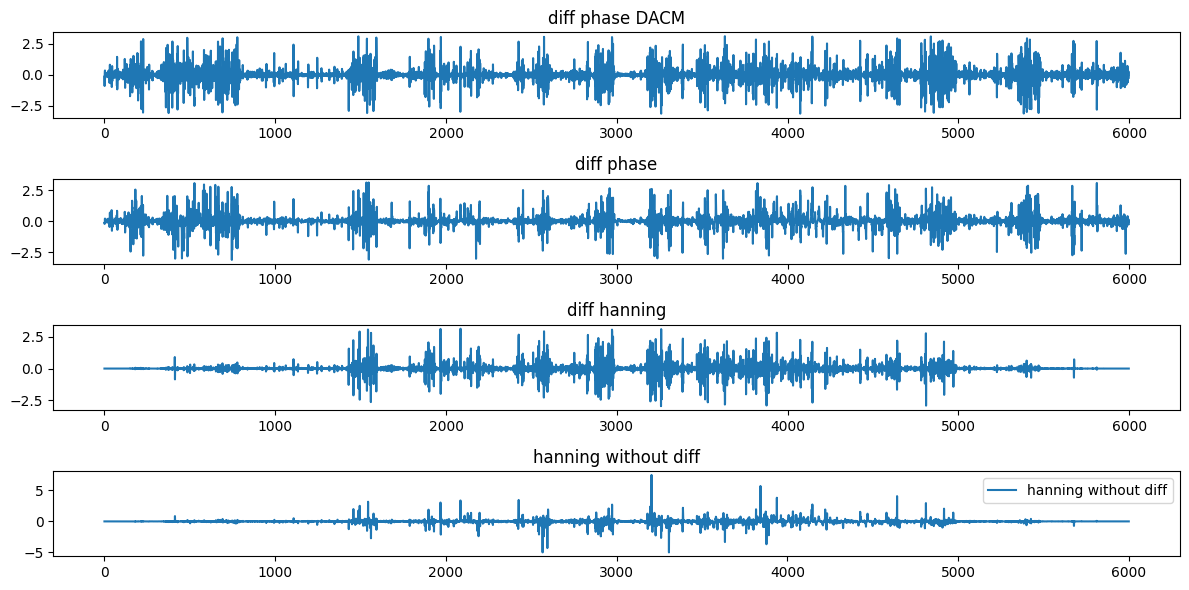

In [53]:
#perform differntial phase

diff_phase_k =np.diff(np.unwrap(np.array(phase_k).flatten()))

diff_interested_bin_angle =np.diff(np.unwrap(np.array(interested_bin_angle).flatten()))
diff_windowed_signal_phase_k_hanning =np.diff(np.unwrap(windowed_signal_phase_k_hanning))
diff_windowed_signal_phase_k_hamming =np.diff(np.unwrap(windowed_signal_phase_k_hamming))

plt.figure(figsize=(12,6))
plt.subplot(4,1,1)
plt.plot(diff_phase_k,label='phase DACM')
plt.title("diff phase DACM")

plt.subplot(4,1,2)
plt.plot(diff_interested_bin_angle,label='phase')
plt.title("diff phase")



plt.subplot(4,1,3)
plt.plot(diff_windowed_signal_phase_k_hanning,label='hanning')
plt.title("diff hanning")



plt.subplot(4,1,4)
plt.plot(windowed_signal_phase_k_hanning,label='hanning without diff')
plt.title("hanning without diff")


plt.tight_layout()
plt.legend()
plt.show()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


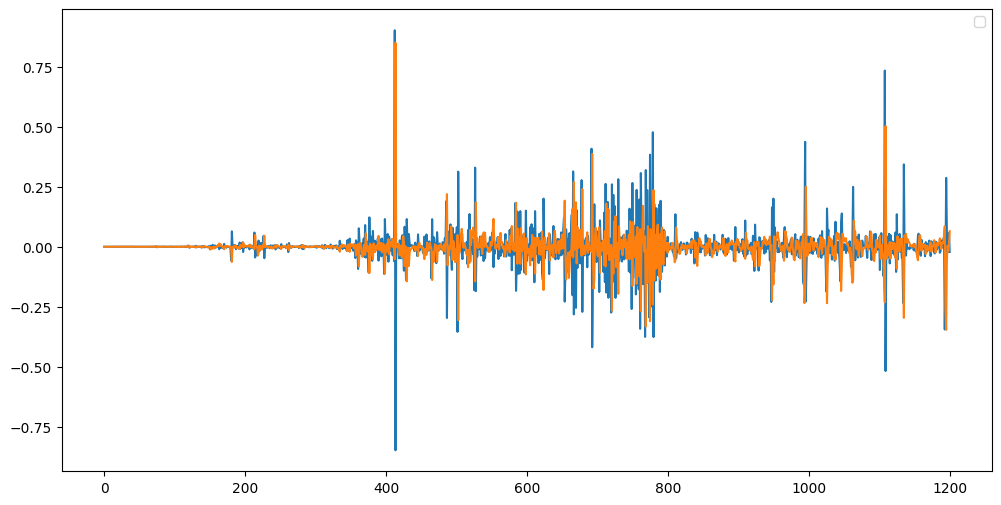

In [54]:

plt.figure(figsize=(12,6))
plt.plot(diff_windowed_signal_phase_k_hamming[0:1200])
plt.plot(windowed_signal_phase_k_hanning[0:1200])

plt.legend()
plt.show()

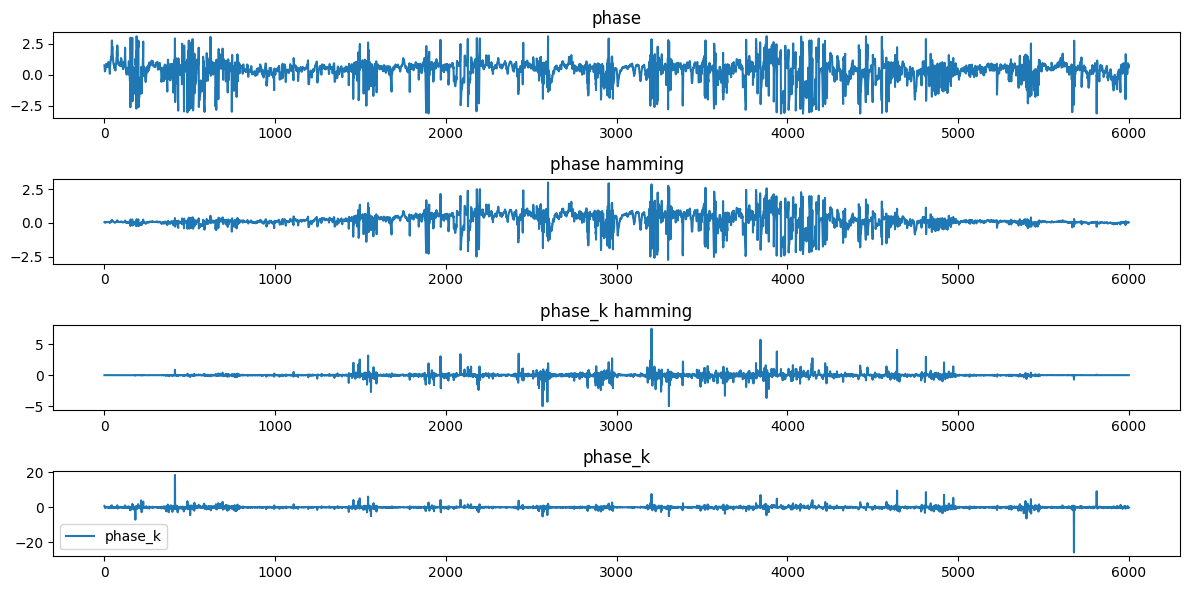

In [57]:
plt.figure(figsize=(12,6))
plt.subplot(411)
plt.plot(interested_bin_angle,label='phase')
plt.title("phase")
plt.subplot(412)
plt.plot(hamming_windowed_signal,label='phase with hamming')
plt.title("phase hamming")
plt.subplot(413)
plt.plot(windowed_signal_phase_k_hamming,label='phase_k with hamming')
plt.title("phase_k hamming")
plt.subplot(414)
plt.plot(phase_k,label='phase_k')
plt.title("phase_k")
plt.tight_layout()
plt.legend()

plt.show()

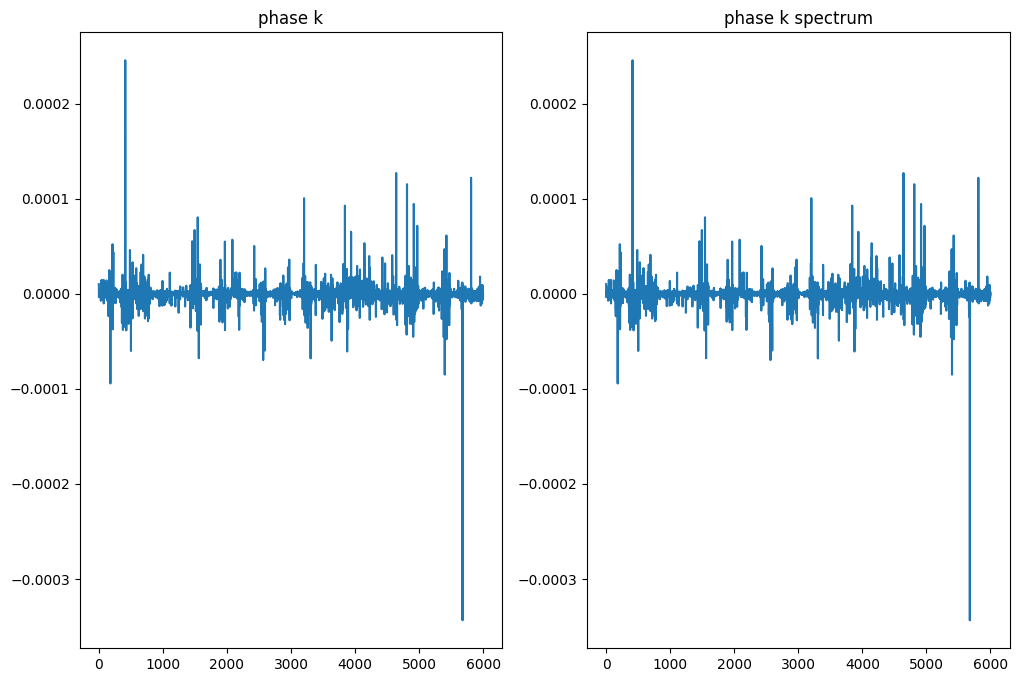

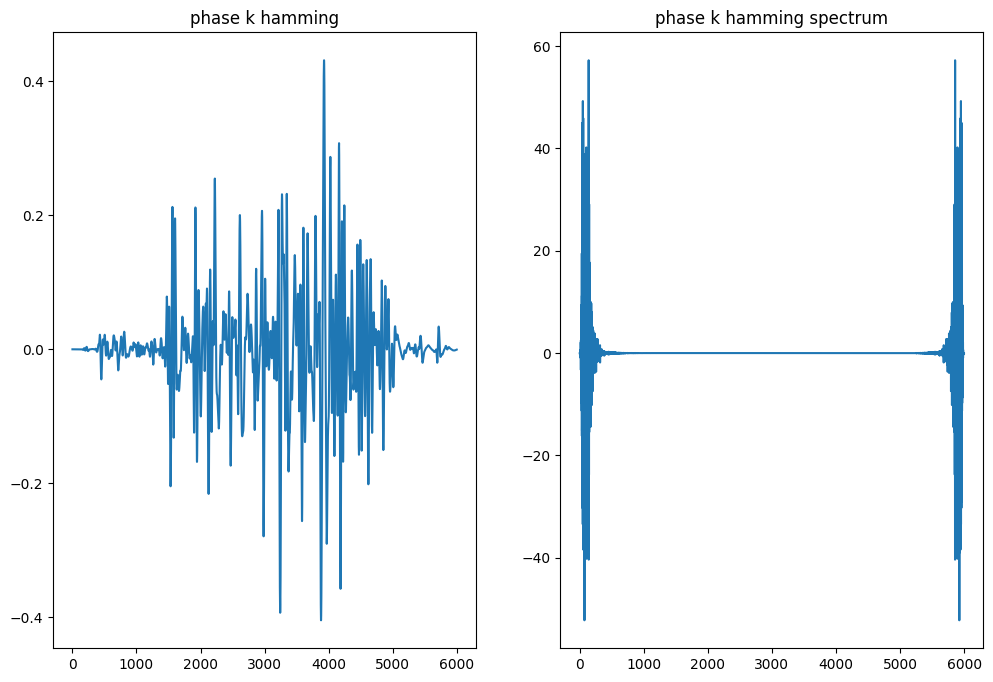

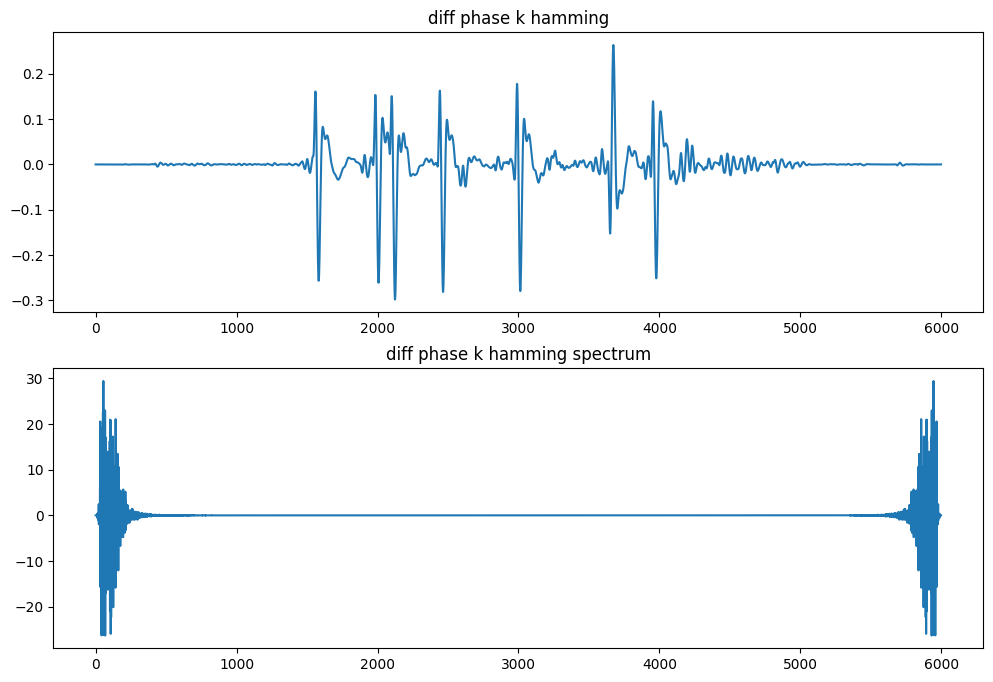

In [92]:
def filter_signal (signal_to_filter ,_low_freq,_high_freq,_sampling_rate,_filter_order):
    sampling_rate = _sampling_rate# Sampling rate of the input signal
    low_freq = _low_freq  # Lower cutoff frequency of the bandpass filter
    high_freq = _high_freq  # Upper cutoff frequency of the bandpass filter
    filter_order = _filter_order # Order of the bandpass filter

    # Compute the normalized cutoff frequencies
    nyquist_freq = 0.5 * sampling_rate
    low_norm = low_freq / nyquist_freq
    high_norm = high_freq / nyquist_freq
    
    # Design the bandpass filter
    b, a = signal.butter(filter_order, [low_norm, high_norm], btype='band')

    # Apply the bandpass filter to the input signal
    signal_filtered = signal.lfilter(b, a, signal_to_filter)
    return signal_filtered

phase_k_filtered =filter_signal(phase_k,0.1,0.5,1200/60,4)
windowed_signal_phase_k_hanning_filtered =filter_signal(windowed_signal_phase_k_hanning,0.1,0.5,1200/60,4)
diff_windowed_signal_phase_k_hanning_filtered =filter_signal(diff_windowed_signal_phase_k_hanning,0.1,0.5,1200/60,4)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 8))  # 1 row, 2 columns

axes[0].set_title("phase k")
axes[0].plot(phase_k_filtered,label ='phase_k')

axes[1].plot(np.fft.fft(phase_k_filtered))
axes[1].set_title("phase k spectrum")
plt.show()

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 8))  # 1 row, 2 columns
axes[0].plot(windowed_signal_phase_k_hanning_filtered,label ='phase_k hamming')
axes[0].set_title("phase k hamming")

axes[1].plot(np.fft.fft(windowed_signal_phase_k_hanning_filtered),label ='phase_k hamming')
axes[1].set_title("phase k hamming spectrum")
plt.show()

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(12, 8))  # 1 row, 2 columns

axes[0].plot(diff_windowed_signal_phase_k_hanning_filtered,label ='phase_k diff')
axes[0].set_title("diff phase k hamming")

axes[1].plot(np.fft.fft(diff_windowed_signal_phase_k_hanning_filtered),label ='phase_k diff')
axes[1].set_title("diff phase k hamming spectrum")

plt.show()



No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


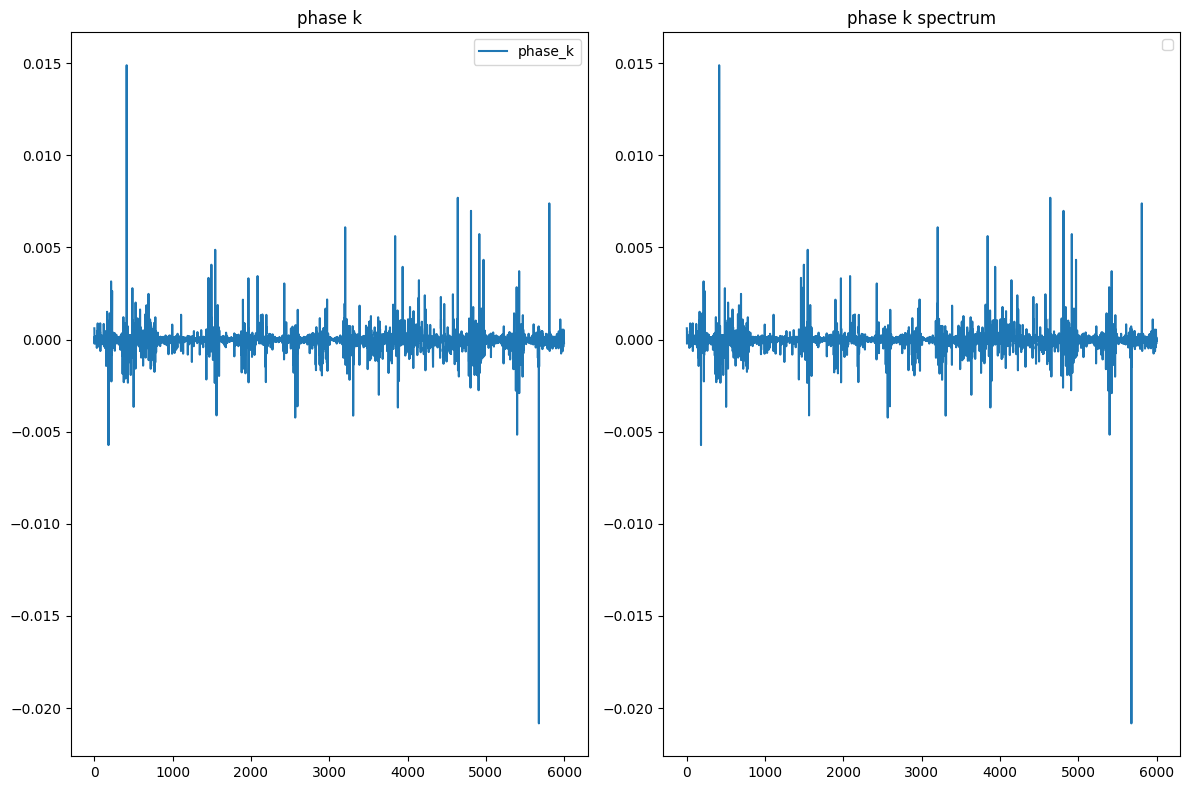

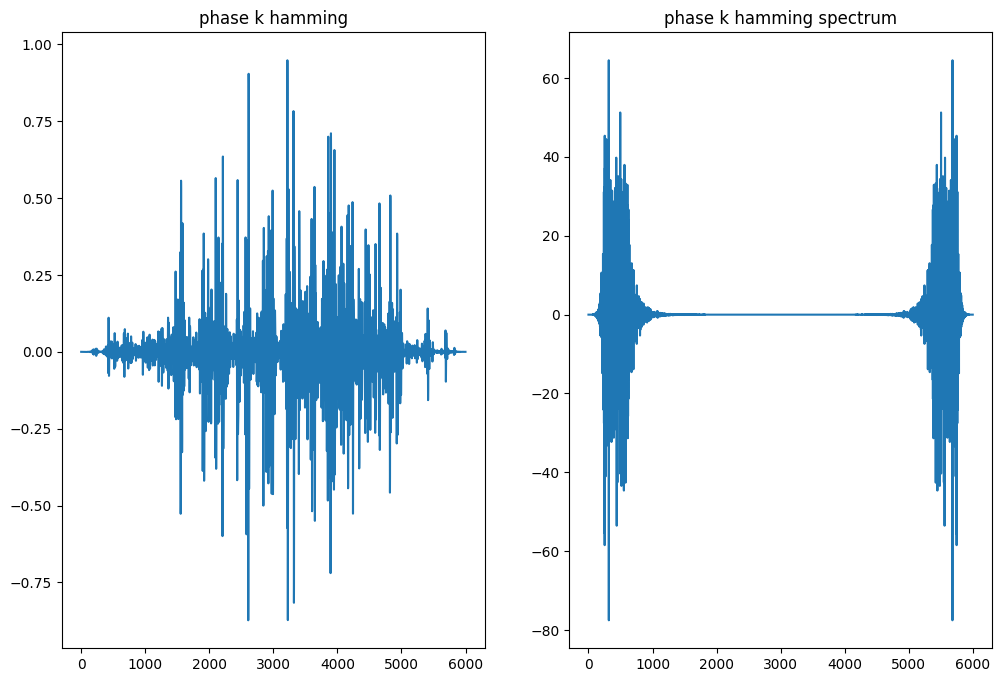

AttributeError: 'numpy.ndarray' object has no attribute 'plot'

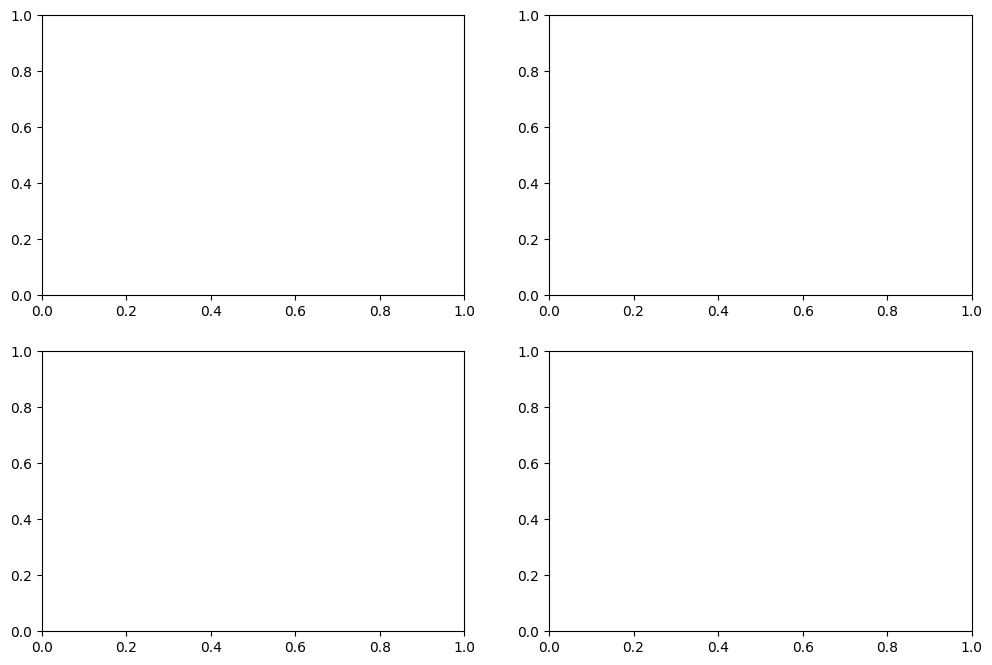

In [93]:
def filter_signal (signal_to_filter ,_low_freq,_high_freq,_sampling_rate,_filter_order):
    sampling_rate = _sampling_rate# Sampling rate of the input signal
    low_freq = _low_freq  # Lower cutoff frequency of the bandpass filter
    high_freq = _high_freq  # Upper cutoff frequency of the bandpass filter
    filter_order = _filter_order # Order of the bandpass filter

    # Compute the normalized cutoff frequencies
    nyquist_freq = 0.5 * sampling_rate
    low_norm = low_freq / nyquist_freq
    high_norm = high_freq / nyquist_freq
    
    # Design the bandpass filter
    b, a = signal.butter(filter_order, [low_norm, high_norm], btype='band')

    # Apply the bandpass filter to the input signal
    signal_filtered = signal.lfilter(b, a, signal_to_filter)
    return signal_filtered

heart_phase_k_filtered =filter_signal(phase_k,0.8,2,1200/60,4)
heart_windowed_signal_phase_k_hanning_filtered =filter_signal(windowed_signal_phase_k_hanning,0.8,2,1200/60,4)
heart_diff_windowed_signal_phase_k_hanning_filtered =filter_signal(diff_windowed_signal_phase_k_hanning,0.8,2,1200/60,4)


fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 8))  # 1 row, 2 columns
axes[0].set_title("phase k")
axes[0].plot(heart_phase_k_filtered,label ='phase_k')
axes[0].legend()
axes[1].plot(np.fft.fft(heart_phase_k_filtered))
axes[1].set_title("phase k spectrum")
axes[1].legend()
plt.tight_layout()
plt.show()

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 8))  # 1 row, 2 columns
axes[0].plot(heart_windowed_signal_phase_k_hanning_filtered,label ='phase_k hamming')
axes[0].set_title("phase k hamming")

axes[1].plot(np.fft.fft(heart_windowed_signal_phase_k_hanning_filtered),label ='phase_k hamming')
axes[1].set_title("phase k hamming spectrum")
plt.show()

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(12, 8))  # 1 row, 2 columns
axes[0].plot(heart_diff_windowed_signal_phase_k_hanning_filtered,label ='phase_k diff')
axes[0].set_title("diff phase k hamming")
axes[1].plot(np.fft.fft(heart_diff_windowed_signal_phase_k_hanning_filtered),label ='phase_k diff')
axes[1].set_title("diff phase k hamming spectrum")

plt.show()



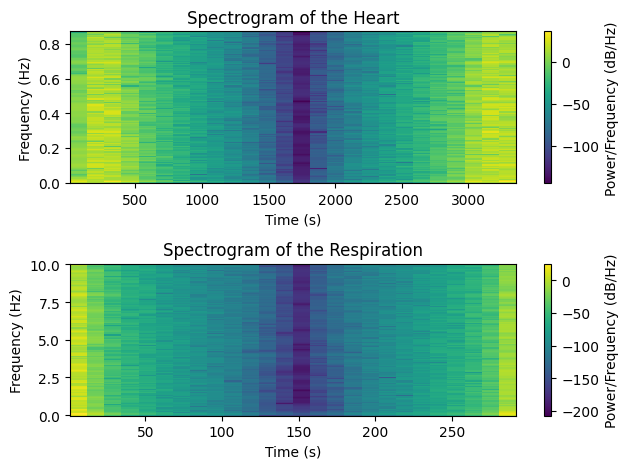

In [84]:
# Compute the spectrogram
def compute_the_spectrogram(_magnitude_signal,_sampling_rate):
    f, t, Sxx = spectrogram(_magnitude_signal, fs=_sampling_rate)
    # Convert magnitude to dB scale for better visualization
    Sxx_db = 10 * np.log10(Sxx)
    return (t,f,Sxx_db)
(h_t,h_f,h_Sdb) =compute_the_spectrogram(np.abs(np.fft.fft(heart_diff_windowed_signal_phase_k_hanning_filtered)),1200/690)
(b_t,b_f,b_Sdb) =compute_the_spectrogram(np.abs(np.fft.fft(diff_windowed_signal_phase_k_hanning_filtered)),1200/60)

# Plot the spectrogram
plt.subplot(2,1,1)
plt.pcolormesh(h_t, h_f, h_Sdb)
plt.colorbar(label='Power/Frequency (dB/Hz)')
plt.title('Spectrogram of the Heart')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')

plt.subplot(2,1,2)
plt.pcolormesh(b_t, b_f, b_Sdb)
plt.colorbar(label='Power/Frequency (dB/Hz)')
plt.title('Spectrogram of the Respiration')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')

plt.tight_layout()
plt.show()